# Lunar Ascent Problem as BVP
Yuri Shimane, 2020/08/19

Problem from Longuski, Pressing (2014) *Optimal Control with Aerospace Application* Appendix A. (pg.215)

The problem involves working out the optimal thrust angle $\alpha$ measured from the local horizontal positive upward to bring a lunar ascent vehicle from the ground to orbit. It assumes a constant mass $m$, constant gravitational acceleration $g_0$ (flat-Moon assumption), and optimizes for the time taken to insert the vehicle into orbit. Hence, the performance measure is

$$
J = t_f
$$

subjected to the dynamics

$$
\begin{align}
    \dot{x} =& v_x   \\
    \dot{y} =& v_y   \\
    \dot{v_x} =& \dfrac{F}{m}\cos{(\alpha)}   \\
    \dot{v_y} =& \dfrac{F}{m}\sin{(\alpha)} - g  \\
\end{align}
$$

where $\alpha$ is the unbounded control. 
The initial conditions and final conditions are given by

$$
\Psi(0) = 
\begin{bmatrix}
    x_0  \\
    y_0  \\
    v_{x,f}   \\
    v_{y,f}
\end{bmatrix}
= \mathbf{0}
\qquad \mathrm{and} \qquad
\Psi(t_f) = 
\begin{bmatrix}
    y_f - h \\
    v_{x,f} - v_c  \\
    v_{y,f}
\end{bmatrix}
= \mathbf{0}
$$

where $h$ and $v_c$ are the altitude and circular orbital velocity at $h$, respectively. 

#### Euler-Lagrange equation and Weierstrass condition
From the Euler-Lagrange theorem, the Hamiltonian is given by

$$
H = p_1 v_x + p_2 v_y + p_3 \left[ \dfrac{F}{m}\cos{(\alpha)} \right] + p_4 \left[ \dfrac{F}{m}\sin{(\alpha)} - g \right]
$$

and the costates ODEs are given by $\dot{\mathbf{p}} = -\dfrac{\partial H}{\partial \mathbf{x}}$

$$
\begin{align}
\dot{p}_1 =& - \dfrac{\partial H}{\partial x_1} = 0  \\
\dot{p}_2 =& - \dfrac{\partial H}{\partial x_2} = 0  \\
\dot{p}_3 =& - \dfrac{\partial H}{\partial x_2} = -p_1  \\
\dot{p}_4 =& - \dfrac{\partial H}{\partial x_2} = -p_2
\end{align}
$$

Since $\alpha$ is unbounded, the control can be expressed from $\dfrac{\partial H}{\partial \alpha} = 0$ as

$$
\dfrac{\partial H}{\partial \alpha} = -p_3 \dfrac{F}{m}\sin{(\alpha)} + p_4 \dfrac{F}{m}\cos{(\alpha)} = 0
$$

hence

$$
\tan{ \alpha } = \dfrac{\pm p_4}{\pm p_3}
$$

or

$$
\begin{align}
\cos{ \alpha } =& \dfrac{ \pm p_3 }{ \sqrt{p_3^2 + p_4^2} }  \\
\sin{ \alpha } =& \dfrac{ \pm p_4 }{ \sqrt{p_3^2 + p_4^2} }
\end{align}
$$

where both $+$ and $-$ signs are still possible. To determine the sign, consider the Weierstrass condition (Pontryargin's Minimum Principle with additional assumption that control is continuous) stating that $\dfrac{\partial^2 H^*}{\partial \mathbf{u^*}^2} \geq 0$

$$
\begin{align}
\dfrac{\partial^2 H}{\partial \alpha^2} &= -p_3 \dfrac{F}{m}\cos{\alpha} - p_4 \dfrac{F}{m}\sin{\alpha} \\
&= \dfrac{F}{m} \left[ -p_3\left( \dfrac{ \pm p_3 }{ \sqrt{p_3^2 + p_4^2} } \right) -p_4\left( \dfrac{ \pm p_4 }{ \sqrt{p_3^2 + p_4^2} } \right) \right] \geq 0
\end{align}
$$

For the above inequality to hold, the signs on the numerator should be $-p_3$ and $-p_4$. 

#### Transversality condition
The fixed final states are $y_f$, $v_{x,f}$, and $v_{y,f}$; hence the transversality condition is given by

$$
H_f dt_f - p_{1,f} dx_f + \phi_{t_f} dt_f + \phi_{x_f} dx_f = 0
$$

where $\phi$ is the Meyer term given by $t_f$, hence

$$
H_f dt_f - p_{1,f} dx_f + dt_f = 0
$$

which provides terminal conditions

$$
\begin{align}
H_f &= -1  \\
p_{1,f} &= 0
\end{align}
$$

Since $\dot{p}_1 = 0$, $p_1(t) = 0$ hence the costate can be dropped entirely. Also, $\dot{p}_3 = -p_1 = 0$. 

### Problem summary
The 7 ODE's are

$$
\begin{align}
    \dot{x} =& v_x   \\
    \dot{y} =& v_y   \\
    \dot{v_x} =& \dfrac{F}{m}\left[ \dfrac{ - p_3 }{ \sqrt{p_3^2 + p_4^2} } \right]   \\
    \dot{v_y} =& \dfrac{F}{m}\left[ \dfrac{ - p_4 }{ \sqrt{p_3^2 + p_4^2} } \right] - g  \\
    \dot{p}_2 =& - \dfrac{\partial H}{\partial x_2} = 0  \\
    \dot{p}_3 =& - \dfrac{\partial H}{\partial x_2} = 0  \\
    \dot{p}_4 =& - \dfrac{\partial H}{\partial x_2} = -p_2
\end{align}
$$

In [1]:
import numpy as np
from scipy.integrate import solve_bvp
import matplotlib.pyplot as plt
from pprint import pprint
plt.rcParams["font.size"] = 16

In [2]:
# canonical unit normalization parameter
h = 185.2e3    # meters, final altitude (100 nmi circular orbit)
Vc = 1.627e3   # m/s, Circular speed at 100 nmi
g_accel = 1.62 # m/sˆ2, gravitational acceleration of Moon
Thrust2Weight = 3  # Thrust to Weight ratio for Ascent Vehicle, in lunar G's
accel = Thrust2Weight*g_accel    # F/m term

In [30]:
def ode_lunarAscent(t, states, p):
    """ODE function must return array with shape (n,m), in the same layout as y"""
    tf = p[0]
    n, m = states.shape
    for j in range(m):
        state = states[:,j]
        # unpack state
        x  = state[0]
        y  = state[1]
        vx = state[2]
        vy = state[3]
        # unpack costates
        # p1dot == 0, p1(tf) == 0 so ode can be omitted; also, p3 == 1
        # p1 == 1 always
        p2 = state[4]   
        p4 = state[5]
        
        # control (in terms of cos(alf), sin(alf))
        cos_alf = 1 / np.sqrt(1**2 + p4**2)    # setting p3 == 1 (nvm!)
        sin_alf = p4 / np.sqrt(1**2 + p4**2)
        
        # initialize array for derivatives
        dstate = np.zeros(n,)
        # derivatives of states
        dstate[0] = tf*( vx )
        dstate[1] = tf*( vy )
        dstate[2] = tf*( accel*cos_alf )
        dstate[3] = tf*( accel*sin_alf - g_accel )
        
        # derivatives of costates
        dstate[4] = tf*( 0 )     # derivative of p2
        dstate[5] = tf*( -p2 )   # derivative of p4
        
        # store
        if j == 0:
            dy = np.reshape(dstate, (n,1))
        else:
            dy = np.concatenate((dy, np.reshape(dstate, (n,1)) ), axis=1)
    return dy

In [31]:
def bc_lunarAscent(ya, yb, p):
    """Boundary conditions must have shape (n+k,), where ya & yb have shape (n,), and p has shape (k,)"""
    res = np.zeros(len(ya)+len(p),)
    
    # ----- initial time boundary conditions ----- #
    res[0] = ya[0]       # x(0)  == 0
    res[1] = ya[1]       # y(0)  == 0
    res[2] = ya[2]       # vx(0) == 0
    res[3] = ya[3]       # vy(0) == 0
    
    # unpack final state
    xf  = yb[0]
    yf  = yb[1]
    vxf = yb[2]
    vyf = yb[3]
#   p1f = 0
#     p2f = yb[4]   
#     p3f = yb[5]
#     p4f = yb[6]
    
    # ----- final time boundary conditions ----- #
    res[4] = yf -  h  # y(tf)  == rc
    res[5] = vxf - Vc # vx(tf) == vc
    res[6] = vyf      # vy(tf) == 0  
    

    return res

In [32]:
# prepare time-domain mesh
x = np.linspace(0, 1, 101)
# prepare initial geuss
y = np.zeros((6, x.size))

In [33]:
tf_guess = 700  # [sec]

In [34]:
# solve bvp
sol = solve_bvp(fun=ode_lunarAscent, bc=bc_lunarAscent, x=x, y=y, p=[tf_guess], verbose=2, bc_tol=1e-12)

   Iteration    Max residual  Max BC residual  Total nodes    Nodes added  
       1          3.57e-03       7.01e-17          101            100      
       2          1.35e-05       2.64e-17          201             0       
Solved in 2 iterations, number of nodes 201. 
Maximum relative residual: 1.35e-05 
Maximum boundary residual: 2.64e-17


In [35]:
sol.y.shape

(6, 201)

In [41]:
# unpack solution
tf = sol.p[0]
sol_mesh = sol.x
times = tf * sol.x
x_star = sol.y[0,:]
y_star = sol.y[1,:]
vx_star = sol.y[2,:]
vy_star = sol.y[3,:]
p2_star = sol.y[4,:]
p4_star = sol.y[5,:]

# reconstruct u
ustar = np.zeros((len(p4_star)))
for j in range(len(p4_star)):
    ustar[j] = (180/np.pi) * np.arctan(p4_star[j])

print(f"tf = {tf}")

tf = 481.20386751750897


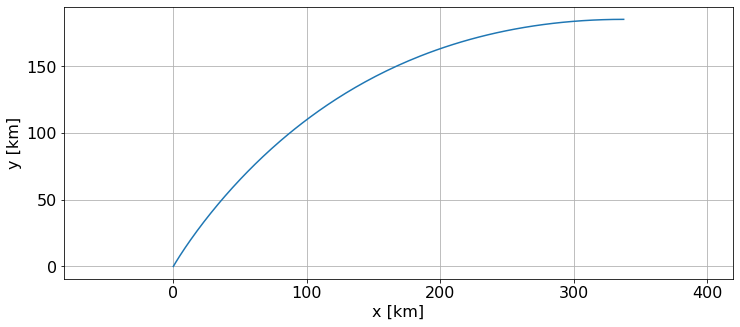

In [37]:
plt.figure(1, figsize=(12, 5))
plt.plot(x_star/1000, y_star/1000)
plt.xlabel("x [km]")
plt.ylabel("y [km]")
plt.axis('equal')
plt.grid(True)
plt.show()

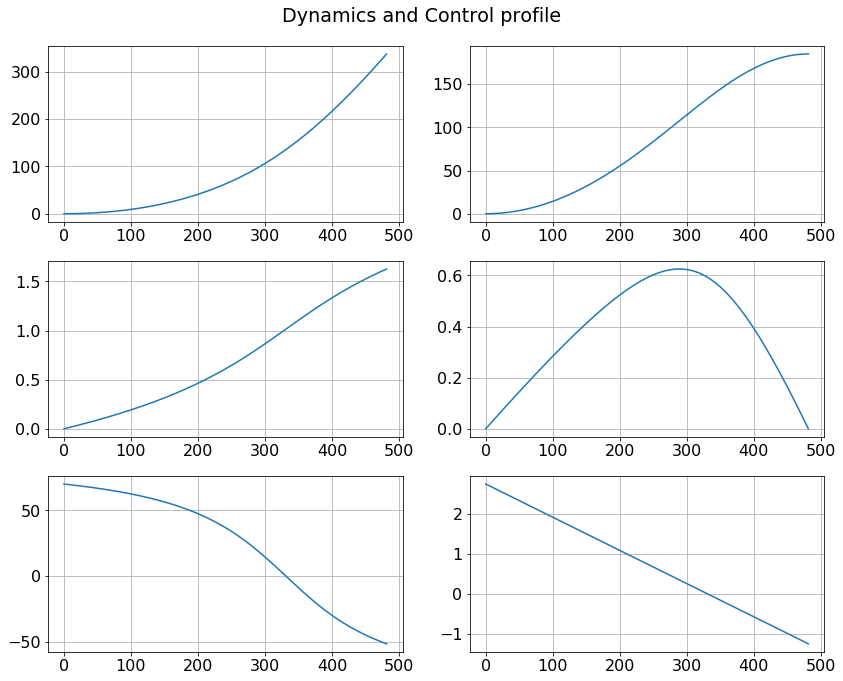

In [38]:
fig, axs = plt.subplots(3,2, figsize=(12, 10))
axs[0,0].plot(times, x_star/1000)
axs[0,0].grid(True)
axs[0,1].plot(times, y_star/1000)
axs[0,1].grid(True)
axs[1,0].plot(times, vx_star/1000)
axs[1,0].grid(True)
axs[1,1].plot(times, vy_star/1000)
axs[1,1].grid(True)
axs[2,0].plot(times, ustar)
axs[2,0].grid(True)
axs[2,1].plot(times, p4_star)
axs[2,1].grid(True)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.suptitle(f'Dynamics and Control profile')
plt.show()